<h1>Building Knowledge Graphs: article_neg_20.txt</h1>
    <h6> I used Prateek Joshi's tutorial at https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/ to complete this assignment</h6> 

<h2> Initial Setup: Loading the libraries that will be used and identifying the directory and file where we will be working.</h2>

In [1]:
#import the libraries that will be used

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
#determine the path to the directory where we will be working

path = "/Users/roman_Sv/Downloads/"
file = open(path+"article_neg_20.txt", "r")

<h2> Part 1: Data Preparation </h2> 
    <h3>Step 1: Perform sentence segmentation - split the text file into separate sentences</h3>

In [3]:
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
data = file.read()
split_file = tokenizer.tokenize(data)
split_file

['Upon receiving the goods there were box scratches, screen scratches.',
 "I don't want to exchange because I hate waiting.",
 "Next time, I'll go buy a mobile phone store.",
 'the phone looks amazing, however, the advertised 45W charging capability is misleading.',
 'only able to achieve 33w max.',
 '(with original samsung 45W charger)\n\nfirst, the transfer of information from old phone to new phone was unclear as you have to connect to WiFi to do so, except you have to connect to the other phones WiFi.',
 'poor instructions there.',
 "spent an hour trying to do this until i realized Samsung just doesn't tell you what needs to be done.",
 'next, the mail, text messaging, and contacts is kinda confusing.',
 "i suppose if you use it long enough you'll get used to it but it really is a terrible system.it seems each manufacture has a way of making life hard on you.",
 "just like us mail, there should be a common way to deliver don't you think?",
 'brand a is not better then brand b etc.'

<h4>Step 1.1: Check that segmentation was done correctly</h4>

<h4> After inspecting the resulting list, it became apparent that after tokenizing the data, some of the sentences were not segmented correctly. For instance, the PROS and CONS paragraphs along with titles of the subsections. Hence, I used a for loop to go through each individual sentence (element of the split file) to check if that element could be split into additional sentences.</h4>

In [4]:
split_new = []
array_length = len(split_file)
for i in range(array_length):   
    split_new.append(split_file[i].splitlines())
split_new

[['Upon receiving the goods there were box scratches, screen scratches.'],
 ["I don't want to exchange because I hate waiting."],
 ["Next time, I'll go buy a mobile phone store."],
 ['the phone looks amazing, however, the advertised 45W charging capability is misleading.'],
 ['only able to achieve 33w max.'],
 ['(with original samsung 45W charger)',
  '',
  'first, the transfer of information from old phone to new phone was unclear as you have to connect to WiFi to do so, except you have to connect to the other phones WiFi.'],
 ['poor instructions there.'],
 ["spent an hour trying to do this until i realized Samsung just doesn't tell you what needs to be done."],
 ['next, the mail, text messaging, and contacts is kinda confusing.'],
 ["i suppose if you use it long enough you'll get used to it but it really is a terrible system.it seems each manufacture has a way of making life hard on you."],
 ["just like us mail, there should be a common way to deliver don't you think?"],
 ['brand a i

<h4> Step 1.2: Load each individual sentence into a separate cell in one column in a CSV file to perform manual inspection that sentences are segmented correctly </h4>

In [5]:
df =  pd.DataFrame(split_new)
df.to_csv(path+'test_exercise2.csv', index=False)

In [6]:
#read in the csv file

candidate_sentences = pd.read_csv(path+"modified_neg.csv")
candidate_sentences.shape

(146, 5)

In [7]:
candidate_sentences['sentence'].sample(5)

109                             when I opened the tracking link
6                                 only able to achieve 33w max.
139                                      What's wrong with you.
57     nothing personal here, just makes you feel like a robot.
136               it cant even do what my 4 year old phone can.
Name: sentence, dtype: object

<h2> Part 2: Concepts Extraction using POS tags </h2> 

<h4> We will be parsing the every sentence's dependency tree. The subject/object were extracted along with their modifiers and the punctuation marks between them.</h4>

<h4> Step 1: Check if individual words are assigned to correct POS tags </h4>

In [8]:
doc = nlp(candidate_sentences['sentence'][9])

for tok in doc:
  print(tok.text, "...", tok.dep_)

you ... nsubj
have ... ROOT
to ... aux
connect ... xcomp
to ... prep
WiFi ... pobj
to ... aux
do ... advcl
so ... advmod
, ... punct


<h4> Step 2: Extract concepts pair (subject, object) using the grammar of the sentences and accounting for the fact that subjects and objects may span over several words.</h4>

In [9]:
def get_concepts(sent):
  
  concept1 = ""
  concept2 = ""

    #next 2 variables hold i-1_th pos tag and text respectively
  prv_tok_dep = ""    
  prv_tok_text = ""  
    
    #next 2 variables hold the text associated with subject/object
  prefix = ""
  modifier = ""

  
    #loop through tokens, add prefix when we come across subject/object that is a compound word
  for tok in nlp(sent):    
    if tok.dep_ != "punct":    
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
            
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
        
    #if token is a subject, append to concept1
      if tok.dep_.find("subj") == True:
        concept1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      
    
    #if token is an object, append to concept2
      if tok.dep_.find("obj") == True:
        concept2 = modifier +" "+ prefix +" "+ tok.text
          
    # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  

  return [concept1.strip(), concept2.strip()]

In [10]:
#check if the function retrieves the concepts pair correctly

get_concepts(candidate_sentences['sentence'][9])

['you', 'WiFi']

In [11]:
#parse through every sentence to receive all concept pairs

concept_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  concept_pairs.append(get_concepts(i))

100%|██████████| 146/146 [00:01<00:00, 84.29it/s] 


In [12]:
#check what concept pairs we got

concept_pairs

[['', 'goods'],
 ['I', ''],
 ['I', ''],
 ['time  I', 'mobile phone store'],
 ['phone', ''],
 ['charging  capability', ''],
 ['', 'only 33w max'],
 ['', '45W  charger'],
 ['first  transfer', 'new  phone'],
 ['you', 'WiFi'],
 ['you', 'other  phones'],
 ['', ''],
 ['i', 'this'],
 ['just  what', 'just  you'],
 ['next  mail', ''],
 ['you', 'it'],
 ['you', 'it'],
 ['it', ''],
 ['life', 'you'],
 ['', 'just  mail'],
 ['you', ''],
 ['a', ''],
 ['i', 'also  fact'],
 ['lot', 'such USB microphones'],
 ['i', 'box it'],
 ['i', 'box'],
 ['i', 'gaming'],
 ['i', 'track recording track apps'],
 ['', 'site recording'],
 ['this', 'you'],
 ['so  it', 'stylus'],
 ['i', 'real  life'],
 ['', 'it'],
 ['who', 'people'],
 ['who', 'it'],
 ['', ''],
 ['this', ''],
 ['i', 'most  phone'],
 ['it', 'text'],
 ['i', 'hand pencil'],
 ['this', 'future'],
 ['kids', 'school'],
 ['you', 'education'],
 ['phone', 'really  anything'],
 ['', 'else  market'],
 ['big  you', 'big  screen'],
 ['', 'favor'],
 ['this', 'less  money'],

<h2> Part 3: Relationships Extraction using POS tags </h2> 

<h4> The following section is based on the assumption that the main verb of the sentence is the predicate </h4>
<h4> The get_relation() is looking for the ROOT POS tage or the main verb in the sentence. Once we get a ROOT, it checks if a ‘prep’ POS tag/agent word follow it. If so, the prer/agent word is added to the main verb.

In [13]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [14]:
#parse through every sentence to receive all relationships between concepts

relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 146/146 [00:01<00:00, 84.07it/s]


In [15]:
#check what the most common relationships are 

pd.Series(relations).value_counts()[:50]

is                8
have              6
was               4
use               4
do                3
said              3
get               3
need              2
but               2
sure              2
be                2
validating        2
arrive            2
did               2
questions in      1
charging          1
is okay           1
lied              1
shipping          1
for               1
deal              1
was unclear       1
Update            1
take for          1
came              1
was like          1
am                1
is for            1
ruined            1
know              1
gone through      1
come Dual         1
pop               1
want              1
damaged at        1
immersed in       1
decided           1
contacted         1
looks amazing     1
with original     1
tou               1
Went unnoticed    1
charged           1
is faulty         1
received          1
's wrong          1
supported such    1
waiting           1
had               1
was open          1


In [16]:
source = [i[0] for i in concept_pairs]

# extract object
target = [i[1] for i in concept_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

<h2> Part 4: Building the Knowledge Graph </h2> 

<h4> We will be building a directed graph (nodes + directed edges) based off the obtained relationships pairs.</h4>


In [17]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

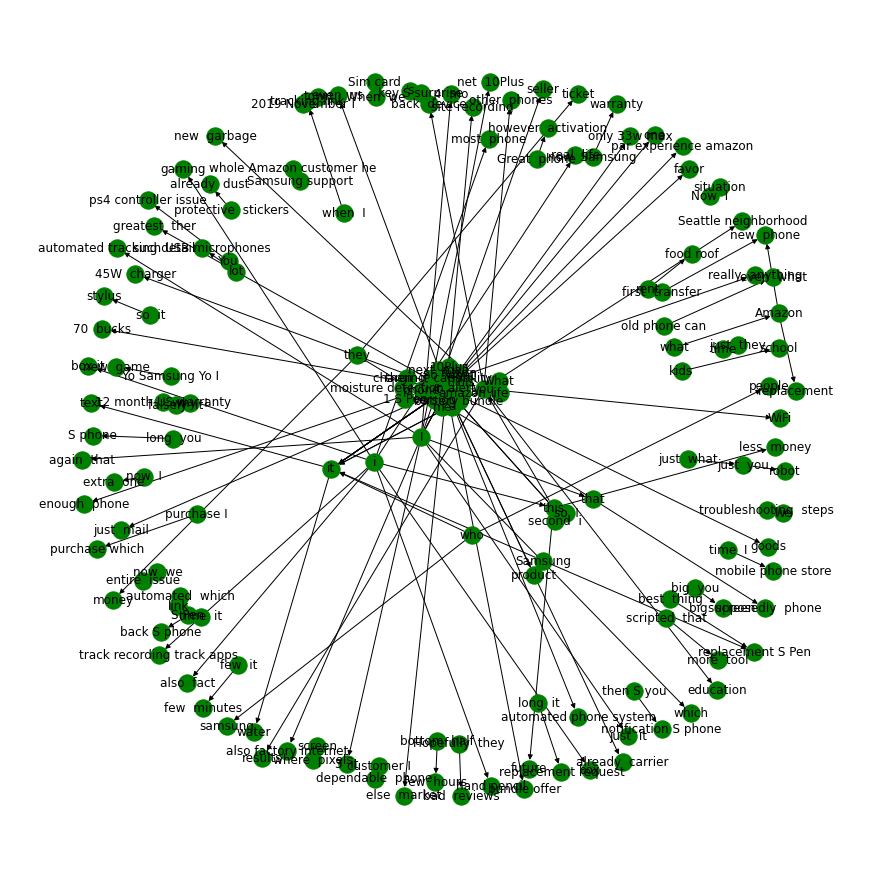

In [18]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='green', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

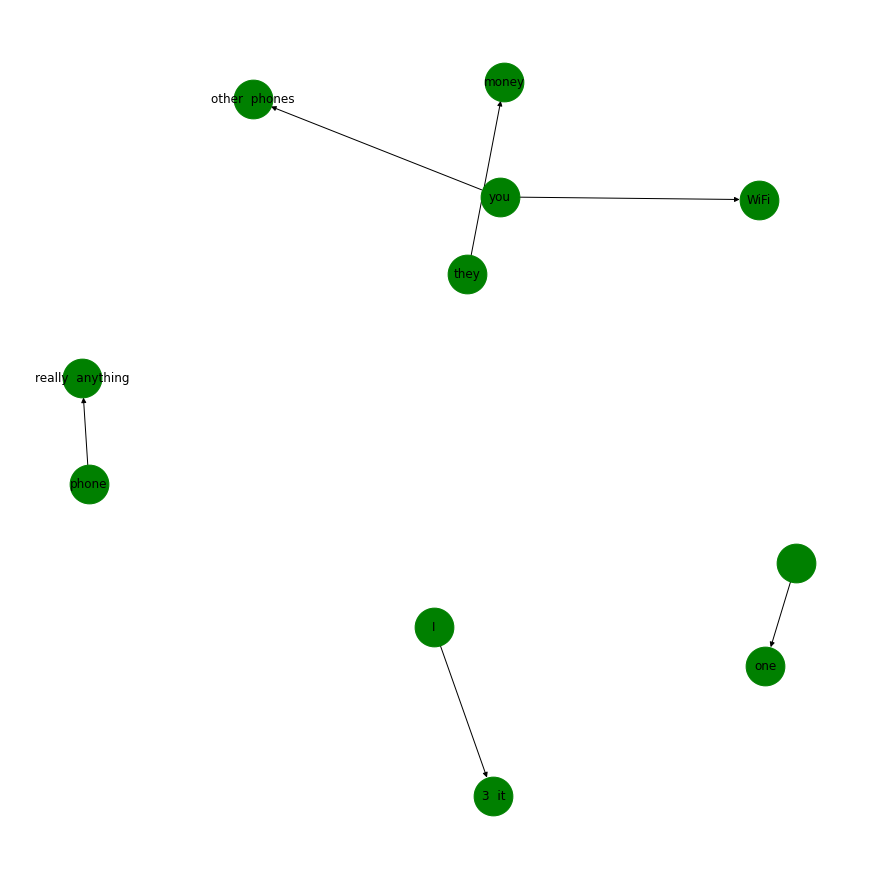

In [19]:
#build a partial knowledge graph with the second most common relationship

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="have"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<h2> Part 5: Limitations and Future Considerations </h2> 

<h4> When I was inspecting sentence segmentation, it became apparent that there were a few outliers, i.e. some sentences included multiple subjects and predicates. Given that all sentences have non-homogenous structure, I decided to manually split such sentences which took me roughly 10 minutes.</h4>

<h4> Furthermore, when I was inspecting the list of the concept pairs obtained, I noticed that some pairs included empty space, i.e. '', as a subject or an object. This definitely has influenced the final graph, however, I would need assistance with figuring out howto fix this issue. </h4>

<h4> Hence, for the future developments and improvements, it is advisable to perform further data inspection and fix the issue with blank spaces. </h4>